### red：Q learning、green：Tiled Net

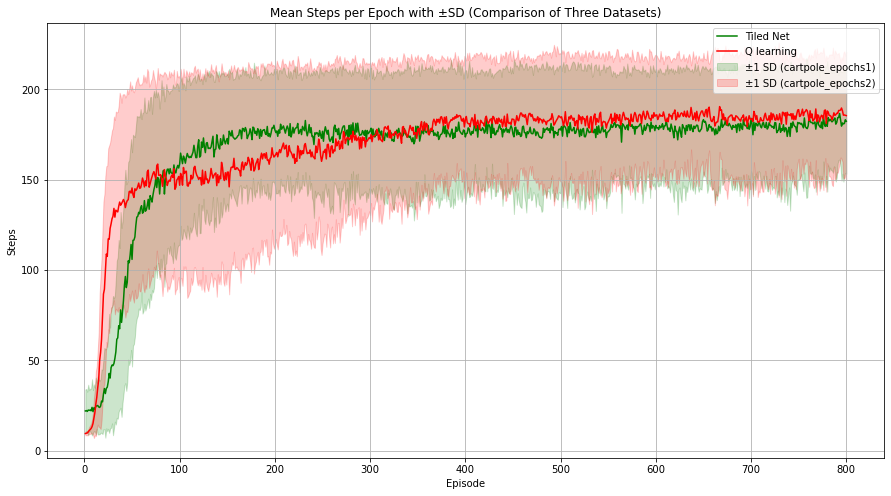

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV files
df1 = pd.read_csv("QBG.csv")  # First file
df2 = pd.read_csv("QL.csv")  # Second file

# Get the maximum value of the `Epoch` column and the `Episode` column
num_epochs = df1["Epoch"].max()
num_episodes = df1["Episode"].max()  

# Create a (200, 800) `numpy` array
data1 = np.zeros((num_epochs, num_episodes))
data2 = np.zeros((num_epochs, num_episodes))
data3 = np.zeros((num_epochs, num_episodes))

# Store data in `numpy` arrays
def fill_data(df, data):
    for _, row in df.iterrows():
        epoch_idx = row["Epoch"] - 1  # Convert to 0-based index
        episode_idx = row["Episode"] - 1  # Convert to 0-based index
        data[epoch_idx, episode_idx] = row["Steps"]

fill_data(df1, data1)
fill_data(df2, data2)

# Calculate the mean and standard deviation for each epoch
def compute_stats(data):
    return np.mean(data, axis=0), np.std(data, axis=0)

epoch_mean1, epoch_std1 = compute_stats(data1)
epoch_mean2, epoch_std2 = compute_stats(data2)

# Plot the graph
plt.figure(figsize=(15, 8))

# Plot each dataset
plt.plot(range(1, num_episodes+1), epoch_mean1, label="Tiled Net", color='g')
plt.fill_between(range(1, num_episodes+1), epoch_mean1 - epoch_std1, epoch_mean1 + epoch_std1, color='g', alpha=0.2, label="±1 SD (cartpole_epochs1)")

plt.plot(range(1, num_episodes+1), epoch_mean2, label="Q learning", color='r')
plt.fill_between(range(1, num_episodes+1), epoch_mean2 - epoch_std2, epoch_mean2 + epoch_std2, color='r', alpha=0.2, label="±1 SD (cartpole_epochs2)")

# Axis labels and title
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Mean Steps per Epoch with ±SD (Comparison of Three Datasets)")

# Display legend
plt.legend()

# Display grid
plt.grid()

# Save the graph to a file
plt.savefig('Learning_results_comparison_three.svg')

# Show the plot
plt.show()


### Graph generation (moving average)

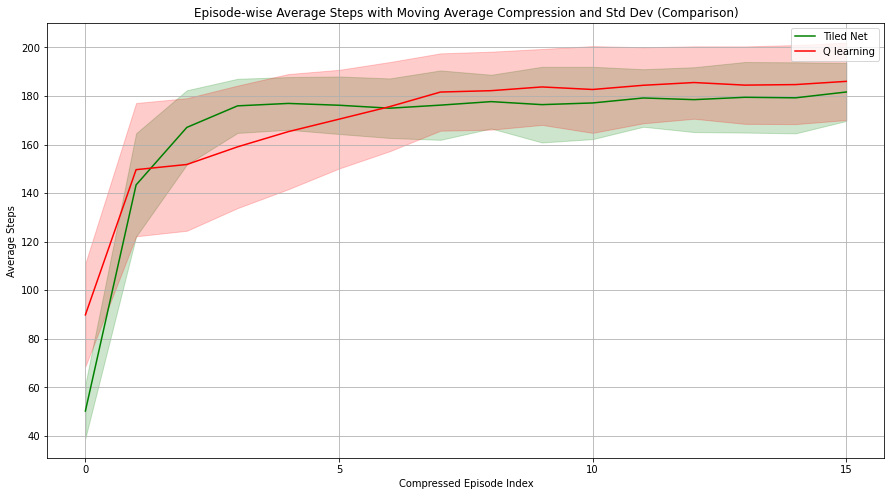

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV files (read two files)
df1 = pd.read_csv("QBG.csv")  # First file
df2 = pd.read_csv("QL.csv")   # Second file

# 1. Calculate the epoch-wise average for each episode in each file
episode_mean1 = df1.groupby(["Epoch", "Episode"])["Steps"].mean().unstack(level=0)
episode_mean2 = df2.groupby(["Epoch", "Episode"])["Steps"].mean().unstack(level=0)

# 2. Apply moving average and compress by episode
num_episodes = len(episode_mean1)
window_size = max(num_episodes // 16, 1)  # Ensure window size is at least 1 to avoid division by zero

compressed_episodes1 = episode_mean1.rolling(window=window_size).mean()[window_size-1::window_size]
compressed_episodes2 = episode_mean2.rolling(window=window_size).mean()[window_size-1::window_size]

# 3. Calculate the compressed mean and standard deviation for each epoch
epoch_mean1 = compressed_episodes1.mean(axis=1).to_numpy()
epoch_std1  = compressed_episodes1.std(axis=1).to_numpy()

epoch_mean2 = compressed_episodes2.mean(axis=1).to_numpy()
epoch_std2  = compressed_episodes2.std(axis=1).to_numpy()

# 4. Change the X-axis to compressed episode indices (integer type)
compressed_x = np.arange(len(epoch_mean1)).astype(int)

# 5. Plot the results (with error shade)
plt.figure(figsize=(15, 8))

# Plot the first dataset
plt.plot(compressed_x, epoch_mean1, linestyle="-", label="Tiled Net", color='g')
plt.fill_between(compressed_x, epoch_mean1 - epoch_std1, epoch_mean1 + epoch_std1, alpha=0.2, color='g')

# Plot the second dataset
plt.plot(compressed_x, epoch_mean2, linestyle="-", label="Q learning", color='r')
plt.fill_between(compressed_x, epoch_mean2 - epoch_std2, epoch_mean2 + epoch_std2, alpha=0.2, color='r')

# Axis labels and title
plt.xlabel("Compressed Episode Index")
plt.ylabel("Average Steps")
plt.title("Episode-wise Average Steps with Moving Average Compression and Std Dev (Comparison)")

# Set X-axis ticks at intervals of 5
plt.xticks(compressed_x[::5])
plt.legend()
plt.grid()

# Save the graph
plt.savefig('Moving_average_comparison_three.svg')
plt.show()


### Moving average（pandas.rolling()）

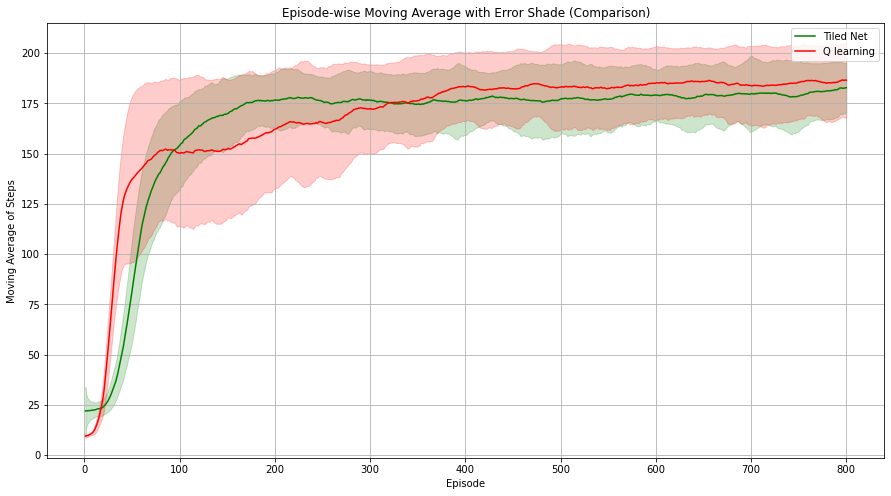

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV files (two files)
df1 = pd.read_csv("QBG.csv")  # First file
df2 = pd.read_csv("QL.csv")   # Second file

# Set the window size for moving average
window_size = 20

# 1. Calculate the moving average for each file
for df in [df1, df2]:
    df["Moving_Avg"] = df.groupby("Epoch")["Steps"].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )

# 2. Calculate the mean and standard deviation of the moving average for each Episode in each file
episode_mean1 = df1.groupby("Episode")["Moving_Avg"].mean()
episode_std1  = df1.groupby("Episode")["Moving_Avg"].std()

episode_mean2 = df2.groupby("Episode")["Moving_Avg"].mean()
episode_std2  = df2.groupby("Episode")["Moving_Avg"].std()

# 3. X-axis (Episode) and Y-axis (mean of moving average)
episodes = episode_mean1.index.to_numpy()

steps_mean1 = episode_mean1.to_numpy()
steps_std1  = np.nan_to_num(episode_std1.to_numpy())  # Convert NaN to 0

steps_mean2 = episode_mean2.to_numpy()
steps_std2  = np.nan_to_num(episode_std2.to_numpy())  # Convert NaN to 0

# 4. Plot with error shade
plt.figure(figsize=(15, 8))

# Tiled Net
plt.plot(episodes, steps_mean1, label="Tiled Net", color="g")
plt.fill_between(episodes, steps_mean1 - steps_std1, steps_mean1 + steps_std1, color="g", alpha=0.2)

# Q-learning
plt.plot(episodes, steps_mean2, label="Q learning", color="r")
plt.fill_between(episodes, steps_mean2 - steps_std2, steps_mean2 + steps_std2, color="r", alpha=0.2)

# Axis labels and title
plt.xlabel("Episode")
plt.ylabel("Moving Average of Steps")
plt.title("Episode-wise Moving Average with Error Shade (Comparison)")

# Legend and grid
plt.legend()
plt.grid()

# Save the graph
plt.savefig('Moving_average_comparison_rolling.svg')

# Display
plt.show()


### Moving average（numpy.convolve()）

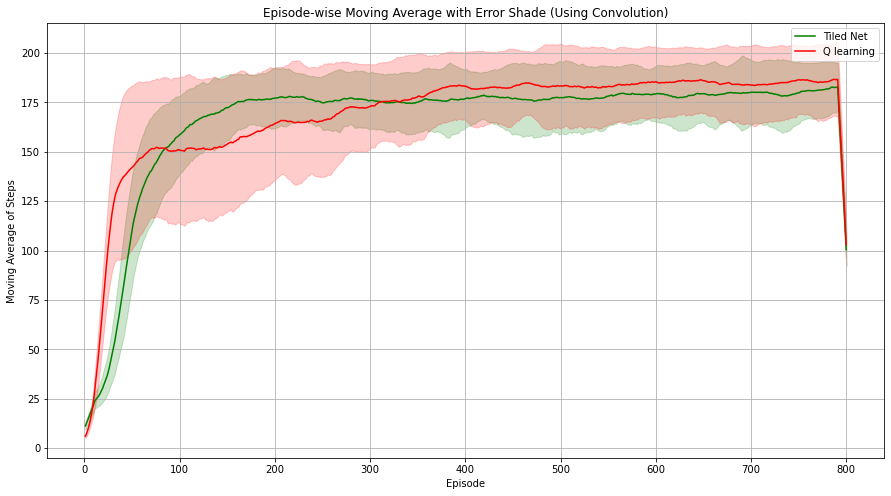

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV files (two files)
df1 = pd.read_csv("QBG.csv")  # First file
df2 = pd.read_csv("QL.csv")   # Second file

# Window size for moving average
window_size = 20
kernel = np.ones(window_size) / window_size

# Apply moving average using np.convolve
def apply_convolve(series):
    result = np.convolve(series, kernel, mode='same')
    return pd.Series(result, index=series.index)

# Add moving average column to each file
df1["Moving_Avg"] = df1.groupby("Epoch")["Steps"].transform(apply_convolve)
df2["Moving_Avg"] = df2.groupby("Epoch")["Steps"].transform(apply_convolve)

# Calculate mean and standard deviation for each Episode
episode_mean1 = df1.groupby("Episode")["Moving_Avg"].mean()
episode_std1  = df1.groupby("Episode")["Moving_Avg"].std()
episode_mean2 = df2.groupby("Episode")["Moving_Avg"].mean()
episode_std2  = df2.groupby("Episode")["Moving_Avg"].std()

# X-axis and Y-axis data
episodes = episode_mean1.index.to_numpy()
steps_mean1 = episode_mean1.to_numpy()
steps_std1  = np.nan_to_num(episode_std1.to_numpy())
steps_mean2 = episode_mean2.to_numpy()
steps_std2  = np.nan_to_num(episode_std2.to_numpy())

# Plot
plt.figure(figsize=(15, 8))

plt.plot(episodes, steps_mean1, label="Tiled Net", color="g")
plt.fill_between(episodes, steps_mean1 - steps_std1, steps_mean1 + steps_std1, color="g", alpha=0.2)

plt.plot(episodes, steps_mean2, label="Q learning", color="r")
plt.fill_between(episodes, steps_mean2 - steps_std2, steps_mean2 + steps_std2, color="r", alpha=0.2)

plt.xlabel("Episode")
plt.ylabel("Moving Average of Steps")
plt.title("Episode-wise Moving Average with Error Shade (Using Convolution)")
plt.legend()
plt.grid()
plt.savefig("Moving_average_comparison_convolve.svg")
plt.show()
